## [cuML](https://github.com/rapidsai/cuml)


As before, all calculations are performed on the GPU.

In [23]:
import cudf
import cuml
import os
import cupy as cp
import subprocess

# Create and populate a GPU DataFrame
df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]
df_float['2'] = [4.0, 2.0, 1.0]

# Setup and fit clusters
dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


## Supervised Learning with cuDF and cuML

In [24]:
# helpers
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

%matplotlib inline

## Linear Regression
After our data has been preprocessed, we often want to build a model so as to understand the relationships between different variables in our data. Scikit-Learn is an incredibly powerful toolkit that allows data scientists to quickly build models from their data. Below we show a simple example of how to create a Linear Regression model.

In [25]:
import numpy as np; print('NumPy Version:', np.__version__)


# create the relationship: y = 2.0 * x + 1.0

n_rows = 4600
w = 2.0
x = np.random.normal(loc=0, scale=1, size=(n_rows,))
b = 1.0
y = w * x + b

# add a bit of noise
noise = np.random.normal(loc=0, scale=2, size=(n_rows,))
y_noisy = y + noise

NumPy Version: 1.20.3


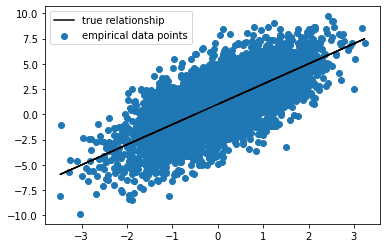

In [26]:
import matplotlib.pyplot as plt

plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.legend()

In [27]:
# Let's use the LinearRegression class from Scikit-Learn to instantiate a model and fit it to our data.

import sklearn; print('Scikit-Learn Version:', sklearn.__version__)
from sklearn.linear_model import LinearRegression


# instantiate and fit model
linear_regression = LinearRegression()

Scikit-Learn Version: 0.23.1


In [28]:
%%time
# let's time it to compare to the gpu processing time with cuML
linear_regression.fit(np.expand_dims(x, 1), y)


CPU times: user 1.88 ms, sys: 0 ns, total: 1.88 ms
Wall time: 1.49 ms


LinearRegression()

In [29]:
# create new data and perform inference
inputs = np.linspace(start=-5, stop=5, num=1000)
outputs = linear_regression.predict(np.expand_dims(inputs, 1))

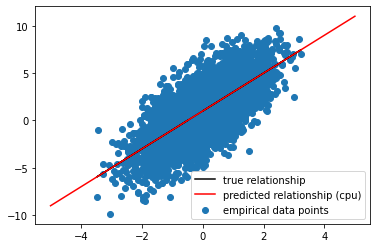

In [30]:
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.legend()

In [31]:
# create a cuDF DataFrame
df = cudf.DataFrame({'x': x, 'y': y_noisy})
print(df.head())

          x         y
0 -0.489105  0.323361
1 -1.132290 -5.205647
2  0.158417  0.433429
3 -1.923132 -5.289183
4  1.823882  2.684320


In [32]:
from cuml.linear_model import LinearRegression as LinearRegression_GPU

# instantiate and fit model
linear_regression_gpu = LinearRegression_GPU()

In [33]:
%%time

linear_regression_gpu.fit(df['x'], df['y'])

/opt/conda/envs/rapids/lib/python3.7/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver from 'eig' to 'svd' as eig solver does not support training data with 1 column currently.
  return func(*args, **kwargs)


CPU times: user 587 ms, sys: 227 ms, total: 814 ms
Wall time: 807 ms


LinearRegression()

In [34]:
# create new data and perform inference
new_data_df = cudf.DataFrame({'inputs': inputs})
outputs_gpu = linear_regression_gpu.predict(new_data_df[['inputs']])

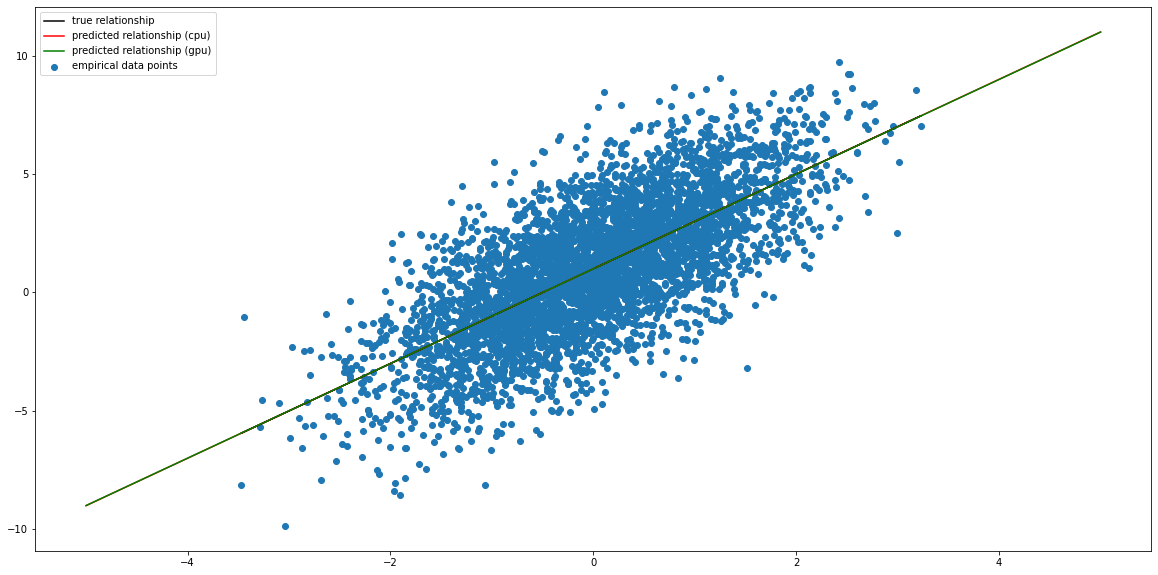

In [35]:
fig, ax = plt.subplots(figsize = (20,10))
plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='predicted relationship (cpu)')
plt.plot(inputs, outputs_gpu.to_array(), color='green', label='predicted relationship (gpu)')
plt.legend()

# we can see from this visualization how the cuML workflow performs differently to that of sklearn modules

## Ridge Regression
Ridge extends LinearRegression by providing L2 regularization on the coefficients when predicting response y with a linear combination of the predictors in X. It can reduce the variance of the predictors, and improves the conditioning of the problem.

Below, we instantiate and fit a Ridge Regression model to our data.

In [36]:
from cuml.linear_model import Ridge as Ridge_GPU


# instantiate and fit model
ridge_regression_gpu = Ridge_GPU()

In [37]:
%%time

ridge_regression_gpu.fit(df[['x']], df['y'])

CPU times: user 8.22 ms, sys: 0 ns, total: 8.22 ms
Wall time: 7.36 ms


/opt/conda/envs/rapids/lib/python3.7/site-packages/cuml/internals/api_decorators.py:409: UserWarning: Changing solver to 'svd' as 'eig' or 'cd' solvers do not support training data with 1 column currently.
  return func(*args, **kwargs)


Ridge()

Similar to the LinearRegression model we fitted early, we can use the predict method to generate predictions for new data.

In [38]:
outputs_gpu = ridge_regression_gpu.predict(new_data_df[['inputs']])


Lastly, we can visualize our Ridge model's estimated relationship and overlay it our the empirical data points.


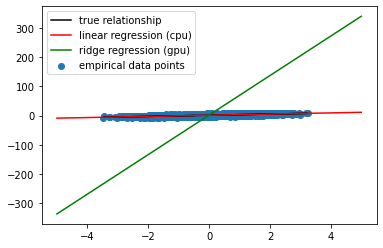

In [39]:
#ask Taurean about this

plt.scatter(x, y_noisy, label='empirical data points')
plt.plot(x, y, color='black', label='true relationship')
plt.plot(inputs, outputs, color='red', label='linear regression (cpu)')
plt.plot(inputs, outputs_gpu.to_array(), color='green', label='ridge regression (gpu)')
plt.legend()

## K Nearest Neighbors
NearestNeighbors is a unsupervised algorithm where if one wants to find the “closest” datapoint(s) to new unseen data, one can calculate a suitable “distance” between each and every point, and return the top K datapoints which have the smallest distance to it.

We'll generate some fake data using the make_moons function from the sklearn.datasets module. This function generates data points from two equations, each describing a half circle with a unique center. Since each data point is generated by one of these two equations, the cluster each data point belongs to is clear. The ideal classification algorithm will identify two clusters and associate each data point with the equation that generated it.

These data points are generated using a non-linear relationship - so using a linear regression approach won't adequately solve problem. Instead, we can use a distance-based algorithm K Nearest Neighbors to classify each data point.

First, let's generate out data.

In [40]:
from sklearn.datasets import make_moons


X, y = make_moons(n_samples=int(1e3), noise=0.05, random_state=0)
print(X.shape)

(1000, 2)


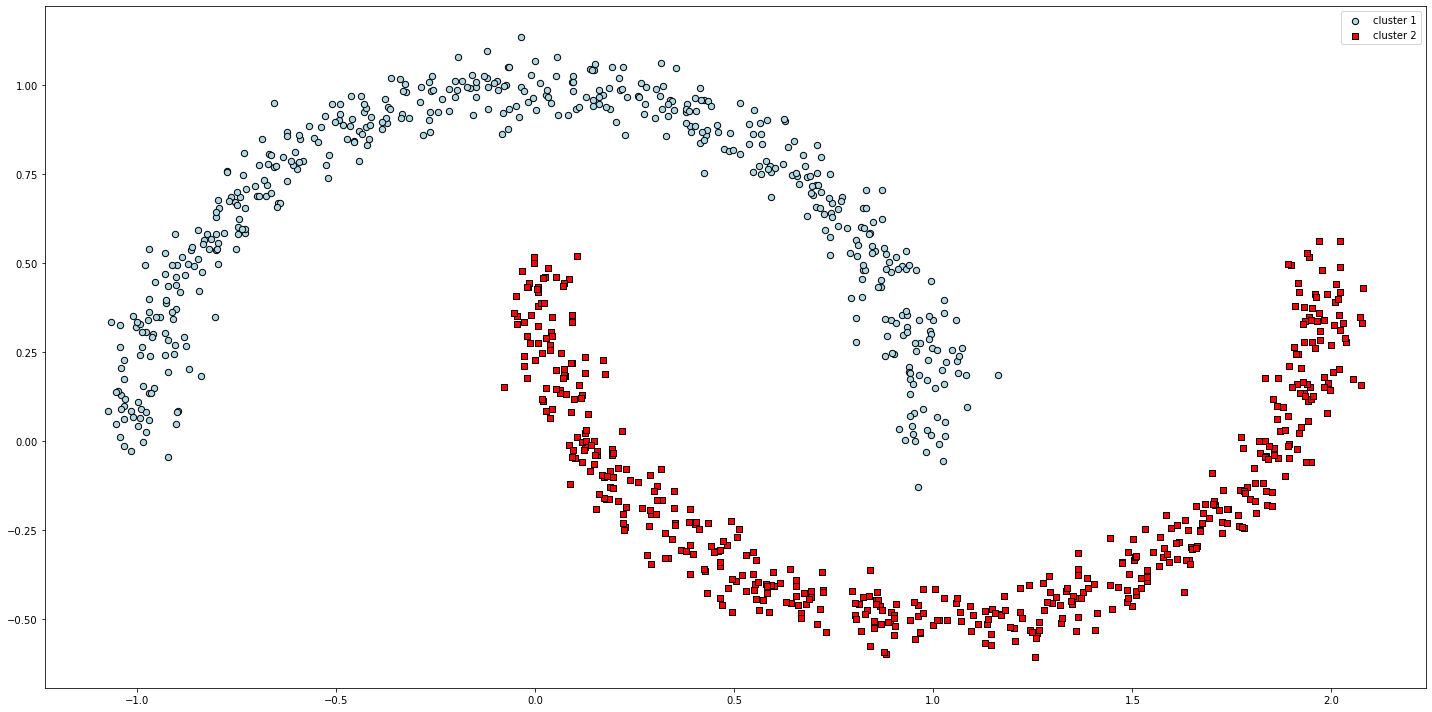

In [41]:
figure, axis = plt.subplots(figsize = (20,10))
axis.scatter(X[y == 0, 0], X[y == 0, 1], 
             edgecolor='black',
             c='lightblue', marker='o', s=40, label='cluster 1')

axis.scatter(X[y == 1, 0], X[y == 1, 1], 
             edgecolor='black',
             c='red', marker='s', s=40, label='cluster 2')
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
# Before we build a KNN classification model, we first have to convert our data to a cuDF representation.
X_df = cudf.DataFrame()
for column in range(X.shape[1]):
    X_df['feature_' + str(column)] = np.ascontiguousarray(X[:, column])

y_df = cudf.Series(y)

In [43]:
from cuml.neighbors import NearestNeighbors


knn = NearestNeighbors()

In [44]:
knn.fit(X_df)


NearestNeighbors()

Once our model has been built and fitted to the data, we can query the model for the k nearest neighbors to each data point. The query returns a matrix representating the distances of each data point to its nearest k neighbors as well as the indices of those neighbors.

In [45]:
k = 3

distances, indices = knn.kneighbors(X_df, n_neighbors=k)

In [46]:
predictions = []
cp_y = cp.asarray(y_df)
for i in range(indices.shape[0]):
    row = indices.iloc[i, :].values
    vote = sum(cp_y[j] for j in row) / k
    predictions.append(1.0 * (vote > 0.5))

predictions = cp.asarray(predictions).astype(np.float32)

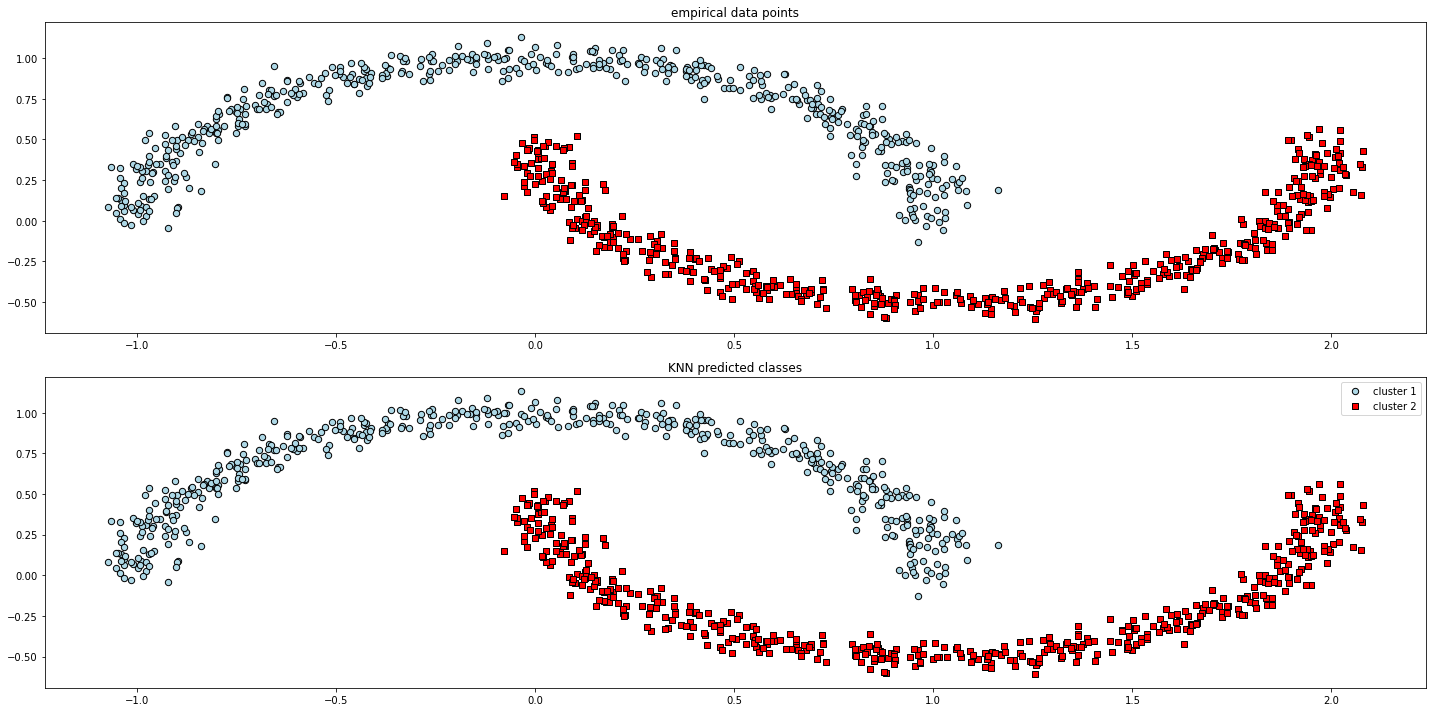

In [47]:

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))


ax1.scatter(X[y == 0, 0], X[y == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y == 1, 0], X[y == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('empirical data points')


ax2.scatter(X[cp.asnumpy(predictions) == 0, 0], X[cp.asnumpy(predictions) == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[cp.asnumpy(predictions) == 1, 0], X[cp.asnumpy(predictions) == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('KNN predicted classes')

plt.legend()
plt.tight_layout()
plt.show()